In [5]:
# gen wf

In [3]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams.update({'font.size': 16}) 

In [4]:
from scipy.interpolate import InterpolatedUnivariateSpline as IUS

In [5]:
import numpy as np

In [6]:
import os

In [7]:
import h5py

In [8]:
# Setup enviroment to autoreload packages
%load_ext autoreload
%autoreload 2
# Turn on inline plotting with matplotlib, and import needed thigs from nrutils
%matplotlib inline
# Let's only import the catalog search function, and the loading function
from nrutils import scsearch,gwylm

(positive)>> Applying custom matplotlib settings.


In [9]:
from nrutils.core.nrsc import *

# build catalogue

In [ ]:
scbuild(keyword='hogshead')

(scbuild)>> Filtering ini files for "hogshead"
(scbuild)>> Opening log file in: /nfshome/store01/users/sebastian.khan/projects/harmonics/nrutils_dev/nrutils/database//hogshead.log
(scbuild)>> Searching for .bbh in /home/sebastian.khan/safelane/hogshead/. This may take a long time if the folder being searched is mounted from a remote drive.
(rfind)>> Seaching for .bbh in /home/sebastian.khan/safelane/hogshead/:
  ->  /home/sebastian.khan/safelane/hogshead/NR_data/ReducedData-hogshead/q1_ASJmodified/q1a04t60_dPm1_T_96_552/psi4modes.bbh
  ->  /home/sebastian.khan/safelane/hogshead/NR_data/ReducedData-hogshead/q1_ASJmodified/q1a04t60_dPm1_T_96_552/q1a04t60_dPm1_T_96_552.bbh
  ->  /home/sebastian.khan/safelane/hogshead/NR_data/ReducedData-hogshead/q1_ASJmodified/q1a04t60_dPm1_T_96_552/q1a04t60_dPm1_T_96_552.raw.bbh
  ->  /home/sebastian.khan/safelane/hogshead/NR_data/ReducedData-hogshead/q1/q1a04t90_dP0_T_96_552/psi4modes.bbh
  ->  /home/sebastian.khan/safelane/hogshead/NR_data/ReducedData-

## Find a simulation(s) using scsearch

In [10]:
help(scsearch)

Help on function scsearch in module nrutils.core.nrsc:

scsearch(catalog=None, q=None, nonspinning=None, spinaligned=None, spinantialigned=None, precessing=None, nonprecessing=None, equalspin=None, unequalspin=None, antialigned=None, setname=None, notsetname=None, institute=None, keyword=None, notkeyword=None, unique=None, plot=None, exists=None, validate_remnant=None, apply_remnant_fit=None, verbose=None)
    # Function for searching through catalog files.



In [11]:
# Search for simulations
# A = scsearch(q=[3.9,8.1], institute='bam', verbose=True)
A = scsearch(institute='bam', verbose=True, precessing=True)

(scsearch)>> Found institute (=bam) keyword.
(scsearch)>> Found precessing (=True) keyword.
(scsearch)>> Found verbose (=True) keyword.
## Found 54 possibly degenerate simulations:
[0001][hogshead] NR_data: 1chi0.80-p-q8.00	(q8a08t150dP2_T_120_480)
[0002][hogshead] NR_data: 1chi0.80-p-q8.00	(q8a08t120dP2_r03_T_96_360)
[0003][hogshead] NR_data: 1chi0.80-p-q8.00	(q8a08t90dP0_T_96_384)
[0004][hogshead] NR_data: 1chi0.80-p-q8.00	(q8a08t60Ditm45dr075_96_360)
[0005][hogshead] NR_data: 1chi0.80-p-q8.00	(q8a08t30dPm9.35_r0.5_T_96_360)
[0006][hogshead] NR_data: 1chi0.40-p-q8.00	(q8a04t150dP9_T_96_360)
[0007][hogshead] NR_data: 1chi0.40-p-q8.00	(q8a04t120dPp1_T_96_360)
[0008][hogshead] NR_data: 1chi0.40-p-q8.00	(q8a04t90dP0_T_96_360)
[0009][hogshead] NR_data: 1chi0.40-p-q8.00	(q8a04t60D_dPm1)
[0010][hogshead] NR_data: 1chi0.40-p-q8.00	(q8a04t30dPm3_T_96_360)
[0011][hogshead] NR_data: 1chi0.80-p-q4.00	(q4a08t150_T_96_360)
[0012][hogshead] NR_data: 1chi0.80-p-q4.00	(q4a08t120dP1_T_96_360)
[0013][h

In [12]:
def get_peak_time(t, amp):
    peak_index = np.argmax(amp)
    peak_time = t[peak_index]
    return peak_time

In [13]:
def resample(x, y, newx):
    return IUS(x, y)(newx)

In [14]:
def compute_sym_waveform(h2m2, h22):
    hplus = (h22 + np.conj(h2m2))/2
    hminus = (h22 - np.conj(h2m2))/2
    return hplus, hminus

In [15]:
def compute_amp(complex_data):
    return np.abs(complex_data)

def compute_phase(complex_data):
    return np.unwrap(np.angle(complex_data))

def compute_dphase(complex_data, time):
    phase = compute_phase(complex_data)
    iphase = IUS(time, phase)
    return iphase.derivative()(time)

In [16]:
def resample_complex(times, complex_data, new_times):
    amp = compute_amp(complex_data)
    phase = compute_phase(complex_data)
    
    new_amp = resample(times, amp, new_times)
    new_phase = resample(times, phase, new_times)
    
    new_complex_data = new_amp * np.exp(1.j * new_phase)
    return new_complex_data

In [17]:
def get_co_prec_sym_waveform(ylm, kind='psi4', t1=None, t2=None, npts=5000):
    
    print("ylm simname {}".format(ylm.simname))
    
    print("kind: {}".format(kind))
    
    print("calc initial j frame")
    ylm_coprec = ylm.__calc_initial_j_frame__()
    
    print("calc coprecessing frame")
    ylm_coprec = ylm_coprec.__calc_coprecessing_frame__()
    
    # use 2nd half of data because junk radiation can be larger than merger peak
    idx = int(len(ylm_coprec.radiation_axis_info.gwylmo[2,2][kind].t)/2)
    # one waveform has a large spike at the very end - step back a bit to avoid it. not very robust!
    end_idx = -500
    t0_coprec = get_peak_time(ylm_coprec.radiation_axis_info.gwylmo[2,2][kind].t[idx:end_idx], ylm_coprec.radiation_axis_info.gwylmo[2,2][kind].amp[idx:end_idx])
    
    t_coprec_shift = ylm_coprec.radiation_axis_info.gwylmo[2,2][kind].t - t0_coprec
    
    if t1 is None:
        t1 = t_coprec_shift[0]
    if t2 is None:
        t2 = t_coprec_shift[-1]
    
    print("t1 = {}".format(t1))
    print("t2 = {}".format(t2))
    
    
    print("computing symmetrised waveform")
    print("**should check sign convention here I use +1.j")
    h2m2_tmp = ylm_coprec[2,-2][kind].wfarr[:,1] + 1.j * ylm_coprec[2,-2][kind].wfarr[:,2]
    h22_tmp = ylm_coprec[2,2][kind].wfarr[:,1] + 1.j * ylm_coprec[2,2][kind].wfarr[:,2]
    
    h22_plus, h22_minus = compute_sym_waveform(h2m2_tmp, h22_tmp)
    print("working with h22_plus")
    
    amp = compute_amp(h22_plus)
    phase = compute_phase(h22_plus)
    dphase = compute_dphase(h22_plus, t_coprec_shift)
    
    newt = np.linspace(t1, t2, npts)

    print("resampling")
    coprec_sym_data = {}
    coprec_sym_data.update({
        't':newt,
        'amp':resample(t_coprec_shift, amp, newt),
        'phi':resample(t_coprec_shift, phase, newt),
        'dphi':resample(t_coprec_shift, dphase, newt),
        'simname':ylm_coprec.simname
    })
    print("**should check sign convention here I use +1.j")
    coprec_sym_data.update({"h22":coprec_sym_data["amp"]*np.exp(1.j*coprec_sym_data["phi"])})
    
    print("done")
    return coprec_sym_data

In [18]:
def my_makedir(path):
    if not os.path.isdir(path):
        os.mkdir(path)
        print("Successfully created the directory '{}' ".format(path))
    else:
        print("directory '{}' already exists".format(path))

In [19]:
def save_data(screnty_ob, output_dir, lmax, gwylm_verbose, verbose, npts):
    if verbose:
        print("\n")
        print(">>>")
        print(">>> working simname: {}".format(obj.simname))
        print(">>>")
        print("\n")
    output_filename = os.path.join(output_dir, "{}.h5".format(obj.simname))
    
    if verbose:
        print("getting gwylm")
    ylm = gwylm( scentry_obj = obj, lmax=lmax, verbose=gwylm_verbose )
    
    coprec_sym_dict = {}
    if verbose:
        print("getting coprec and sym waveform [psi4]")
    coprec_sym_dict['psi4'] = get_co_prec_sym_waveform(ylm, kind='psi4')
    if verbose:
        print("getting coprec and sym waveform [strain]")
    coprec_sym_dict['strain'] = get_co_prec_sym_waveform(ylm, kind='strain')
    
    plt.figure()
    plt.plot(coprec_sym_dict['psi4']['t'], coprec_sym_dict['psi4']['amp'])
    plt.plot(coprec_sym_dict['strain']['t'], coprec_sym_dict['strain']['amp'])
    plt.show()
    plt.close()
    
    # the times from psi4 and strain or not the same so we should
    # resample to common times
    print("*****")
    print([coprec_sym_dict['psi4']['t'][0], coprec_sym_dict['strain']['t'][0]])
    print([coprec_sym_dict['psi4']['t'][-1], coprec_sym_dict['strain']['t'][-1]])
    print("*****")
    common_t1 = np.max([coprec_sym_dict['psi4']['t'][0], coprec_sym_dict['strain']['t'][0]])
    common_t2 = np.min([coprec_sym_dict['psi4']['t'][-1], coprec_sym_dict['strain']['t'][-1]])
    print("common_t1: {}".format(common_t1))
    print("common_t2: {}".format(common_t2))
    


    if verbose:
        print("resampling psi4 and strain to a common time grid")
    new_times = np.linspace(common_t1, common_t2, npts)
    psi4_data = resample_complex(coprec_sym_dict['psi4']['t'], coprec_sym_dict['psi4']['h22'], new_times)
    strain_data = resample_complex(coprec_sym_dict['psi4']['t'], coprec_sym_dict['strain']['h22'], new_times)
    
    if verbose:
        print("making file: {}".format(output_filename))
    with h5py.File(output_filename, "w") as f:
        f.attrs['simname'] = obj.simname
        f.attrs['X1'] = obj.X1
        f.attrs['X2'] = obj.X2
        f.attrs['eta'] = obj.eta
        
        f.create_dataset("times", data=new_times)
        f.create_dataset("psi4", data=psi4_data)
        f.create_dataset("strain", data=strain_data)

In [20]:
A[:2]

[<nrutils.core.nrsc.scentry instance at 0x2b9f61811ab8>,
 <nrutils.core.nrsc.scentry instance at 0x2b9f6188dfc8>]

In [21]:
# explicit list of sims from EZH
sims = ['q1a04t30_dPm2_T_96_552', 'q1a04t60_dPm1_T_96_552', 'q1a04t90_dP0_T_96_552', 'q1a04t120_dP0_T_96_552', 'q1a04t150_dP0_T_96_552',  'q1a08t30dPm25_T_96_408', 'q1a08t60dPm1.5_T_96_408', 'q1a08t90dPm1_T_96_408', 'q1a08t120dP0_T_96_408', 'q1a08t150dP0_T_96_408', 'q2a04t30dPm2_T_96_408', 'q2a04t60dPm1_T_96_408', 'q2a04t90dPm1_T_96_408', 'q2a04t120_T_96_408', 'q2a04t150_T_96_408', 'q2_a10_a28_ph0_th30', 'q2_a10_a28_ph0_th60', 'q2_a10_a28_ph0_th90', 'q2_a10_a28_ph0_th120', 'q2_a10_a28_ph0_th150', 'q4a04t30_T_96_360', 'q4a04t60dPm1.5D_T_96_360', 'q4a04t90_T_96_360', 'q4a04t120dP0D_T_96_360', 'q4a04t150_T_96_360', 'q4a08t30dPm5p5dRm47_T_96_360', 'q4a08t60dPm3dRm250_T_96_384', 'q4a08t90dPm1D_T_96_384', 'q4a08t120dP1_T_96_360', 'q4a08t150_T_96_360',  'q8a04t30dPm3_T_96_360', 'q8a04t60D_dPm1', 'q8a04t90dP0_T_96_360', 'q8a04t120dPp1_T_96_360', 'q8a04t150dP9_T_96_360', 'q8a08t30dPm9.35_r0.5_T_96_360', 'q8a08t60Ditm45dr075_96_360', 'q8a08t90dP0_T_96_384', 'q8a08t120dP2_r03_T_96_360', 'q8a08t150dP2_T_120_480']

In [22]:
count=0
for i, obj in enumerate(A):
    if obj.simname in sims:
        print(i, obj.simname)
        count=count+1
print(count)

(0, 'q8a08t150dP2_T_120_480')
(1, 'q8a08t120dP2_r03_T_96_360')
(2, 'q8a08t90dP0_T_96_384')
(3, 'q8a08t60Ditm45dr075_96_360')
(4, 'q8a08t30dPm9.35_r0.5_T_96_360')
(5, 'q8a04t150dP9_T_96_360')
(6, 'q8a04t120dPp1_T_96_360')
(7, 'q8a04t90dP0_T_96_360')
(8, 'q8a04t60D_dPm1')
(9, 'q8a04t30dPm3_T_96_360')
(10, 'q4a08t150_T_96_360')
(11, 'q4a08t120dP1_T_96_360')
(12, 'q4a08t90dPm1D_T_96_384')
(13, 'q4a08t60dPm3dRm250_T_96_384')
(14, 'q4a08t30dPm5p5dRm47_T_96_360')
(15, 'q4a04t150_T_96_360')
(17, 'q4a04t120dP0D_T_96_360')
(18, 'q4a04t90_T_96_360')
(19, 'q4a04t60dPm1.5D_T_96_360')
(20, 'q4a04t30_T_96_360')
(22, 'q2_a10_a28_ph0_th150')
(24, 'q2_a10_a28_ph0_th120')
(26, 'q2_a10_a28_ph0_th90')
(27, 'q2_a10_a28_ph0_th60')
(29, 'q2_a10_a28_ph0_th30')
(30, 'q2a04t150_T_96_408')
(31, 'q2a04t120_T_96_408')
(32, 'q2a04t90dPm1_T_96_408')
(33, 'q2a04t60dPm1_T_96_408')
(34, 'q2a04t30dPm2_T_96_408')
(35, 'q1a08t150dP0_T_96_408')
(36, 'q1a08t120dP0_T_96_408')
(37, 'q1a08t90dPm1_T_96_408')
(38, 'q1a08t60dPm1.5

In [23]:
ylm = gwylm( scentry_obj = A[8], lmax=2, verbose=True )

(gwylm)>> Found dt (=0.15) keyword.
(gwylm)>> Found enforce_m_relative_sign_convention (=True) keyword.
(gwylm)>> Found lmax (=2) keyword.
(gwylm)>> Found load_dynamics (=True) keyword.
(gwylm)>> Found scentry_obj (=<nrutils.core.nrsc.scentry instance at 0x2b9f618603f8>) keyword.
(gwylm)>> Found verbose (=True) keyword.
(__init__)>> Using default M_RELATIVE_SIGN_CONVENTION of 1
(gwylm)>> The (extraction_parameter,level) is (5,7), which differs from the config values of (5,5). You have either manually input the non-config values, or the handler has set them by looking at the contents of the simulation directory. 
(__make_lmlist__)>> The following spherical multipoles will be loaded:[(2, 2), (2, -2), (2, -1), (2, 0), (2, 1)]
(load)>> Using the default extraction_parameter of 5
(load)>> Using the default level of 7
(load)>> Loading: psi3col.r5.l7.l2.m2.gz
(straighten_wfarr!)>> The time series has been found to be non-monotonic. We will sort the data to enforce monotinicity.
(straighten_wf

/home/sebastian.khan/.conda/envs/nrutils/lib/python2.7/site-packages/positive/learning.py:2561: RuntimeWarning: invalid value encountered in divide
  weights = (r-amin(r)) / amax( r-amin(r) )


(gwylm)>> Storing w22 from a PN estimate[see pnw0 in basics.py, and/or arxiv:1310.1528v4]. This will be the frequency parameter used if strain is to be calculated.
(calcflm)>> w0(w22) = 0.050798 (this is the lower frequency used for FFI method [arxiv:1006.1632v3])
(calcflm)>> w0(w22) = -0.050798 (this is the lower frequency used for FFI method [arxiv:1006.1632v3])
(calcflm)>> w0(w22) = -0.025399 (this is the lower frequency used for FFI method [arxiv:1006.1632v3])
(calcflm)>> w0(w22) = 0.050798 (this is the lower frequency used for FFI method [arxiv:1006.1632v3])
(calcflm)>> w0(w22) = 0.025399 (this is the lower frequency used for FFI method [arxiv:1006.1632v3])
(calchlm)>> w22 = m*w22/2 = 0.050798 (this is the lower frequency used for FFI method [arxiv:1006.1632v3])
(gwylm.calchlm)>> The user should note that there is no minus sign used in front of the double time integral for strain (i.e. Eq 4 of arxiv:1006.1632). This differs from Eq 3.4 of arxiv:0707.4654v3. The net effect is a rot

In [25]:
ylm.metadata_file_location

'/home/sebastian.khan/safelane/hogshead/NR_data/ReducedData-hogshead/q8precessing/q8a04t60D_dPm1/q8a04t60D_dPm1.bbh'

In [26]:
ylm[2,2]['psi4']

<nrutils.core.nrsc.gwf instance at 0x2b9f63eefa70>

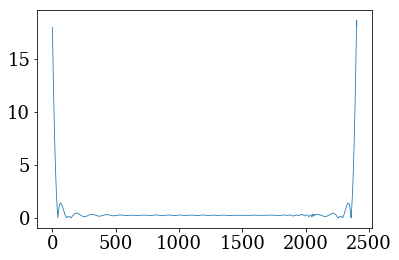

In [30]:
plt.figure()
# plt.plot(ylm[2,2]['psi4'].t, ylm[2,2]['psi4'])
# plt.plot(ylm[2,2]['psi4'].t, ylm[2,2]['psi4'].plus)
plt.plot(ylm[2,2]['strain'].t, ylm[2,2]['strain'].amp)


# plt.axvline(ylm[2,2]['psi4'].t[-500])


directory 'data' already exists


 saving q8a04t60D_dPm1




>>>
>>> working simname: q8a04t60D_dPm1
>>>


getting gwylm

# -~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~ #
(load_dynamics)>> Trying to load source dynamics ...
# -~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~ #

(load_dynamics)>> Calculating dynamics times by adjusting input waveform_times by extraction radius
(load_dynamics)>> Retrieving method from handler for loading source dyanmics as this is specific to BAM, GT-MAYA, SXS, etc ...
(load_dynamics)>> Loading/Learning dynamics ...
(straighten_wfarr!)>> The time series has been found to be non-monotonic. We will sort the data to enforce monotinicity.
(straighten_wfarr!)>> The waveform time series is now monotonic.
(straighten_wfarr!)>> Repeated time values were found in the array. Offending rows will be removed.
(straighten_wfarr!)>> The time series has been found to be non-monotonic. We will sort the data to enforce monotinicity.
(straigh

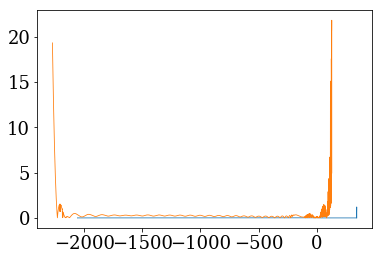

*****
[-2057.85, -2272.65]
[344.25, 129.44999999999982]
*****
common_t1: -2057.85
common_t2: 129.45
resampling psi4 and strain to a common time grid
making file: data/q8a04t60D_dPm1.h5
CPU times: user 37.7 s, sys: 353 ms, total: 38 s
Wall time: 38.2 s


In [133]:
%%time
lmax=2
gwylm_verbose=False
verbose=True
output_dir='data'
npts=5000
my_makedir(output_dir)
for obj in [A[8]]:
# for obj in [A[53]]:
    if obj.simname in sims:
        if "ASJmodified" not in obj.metadata_file_location:
            print("\n\n saving {}\n\n".format(obj.simname))
            save_data(screnty_ob=obj, output_dir=output_dir, lmax=lmax, gwylm_verbose=gwylm_verbose, verbose=verbose, npts=npts)
    else:
        print("\n\n skipping {}".format(obj.simname))

In [134]:
def read_data(filename):
    with h5py.File(filename, 'r') as f:
        print(f.keys())
        print(f.attrs.keys())
        print(f['times'])
        
        fig, axes = plt.subplots(1, 2, figsize=(14,5))
        axes[0].plot(f['times'], np.real(f['psi4']))
        axes[1].plot(f['times'], np.real(f['strain']))
#         axes[0].set_xlim(-100,100)
#         axes[1].set_xlim(-100,100)
        fig.suptitle(filename)
        
        psi4_phi = compute_phase(f['psi4'])
        strain_phi = compute_phase(f['strain'])
        
        fig, axes = plt.subplots(1, 2, figsize=(14,5))
        axes[0].plot(f['times'], psi4_phi)
        axes[1].plot(f['times'], strain_phi)
#         axes[0].set_xlim(-100,100)
#         axes[1].set_xlim(-100,100)



        psi4_dphi = compute_dphase(f['psi4'], f['times'])
        strain_dphi = compute_dphase(f['strain'], f['times'])
        
        fig, axes = plt.subplots(1, 2, figsize=(14,5))
        axes[0].plot(f['times'], psi4_dphi)
        axes[1].plot(f['times'], strain_dphi)
#         axes[0].set_xlim(-100,100)
#         axes[1].set_xlim(-100,100)
        plt.show()
        plt.close()
        return f['times'][:], f['psi4'][:]

[u'psi4', u'strain', u'times']
[u'X1', u'X2', u'eta', u'simname']
<HDF5 dataset "times": shape (5000,), type "<f8">


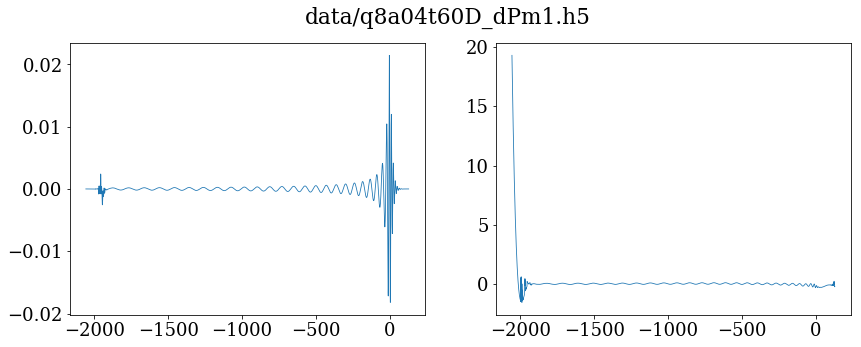

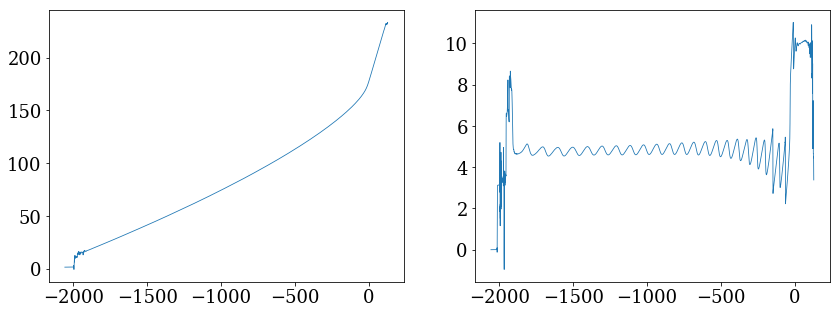

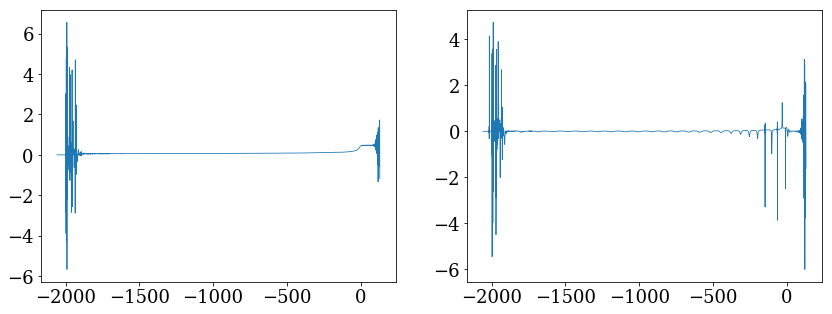

In [135]:
# t, psi4 = read_data('data/q8a08t150dP2_T_120_480.h5')
# t, psi4 = read_data('../../data/q8a04t60D_dPm1.h5')
t, psi4 = read_data('data/q8a04t60D_dPm1.h5')

# t, psi4 = read_data('data/q1a04t60_dPm1_T_96_552.h5')

In [78]:
import glob

In [79]:
all_data = glob.glob('data/*.h5')

[u'psi4', u'strain', u'times']
[u'X1', u'X2', u'eta', u'simname']
<HDF5 dataset "times": shape (5000,), type "<f8">


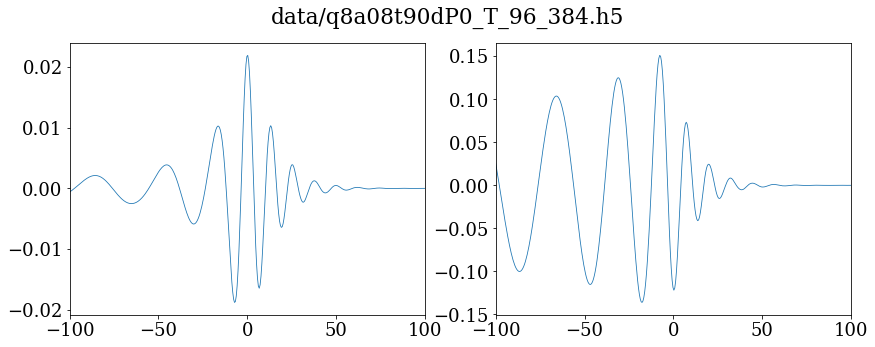

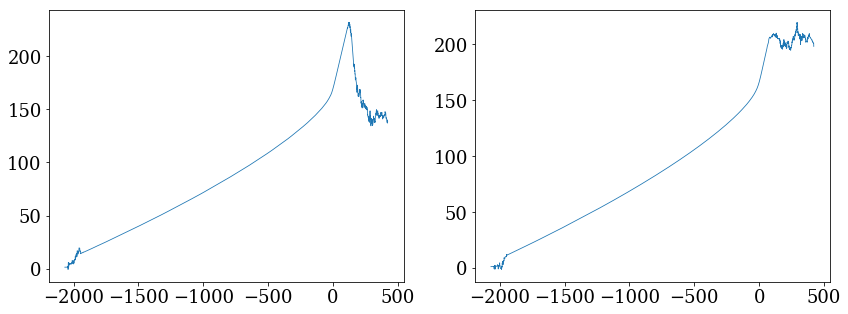

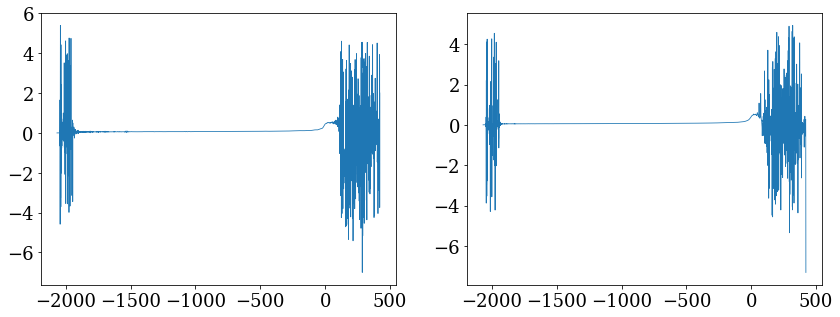

[u'psi4', u'strain', u'times']
[u'X1', u'X2', u'eta', u'simname']
<HDF5 dataset "times": shape (5000,), type "<f8">


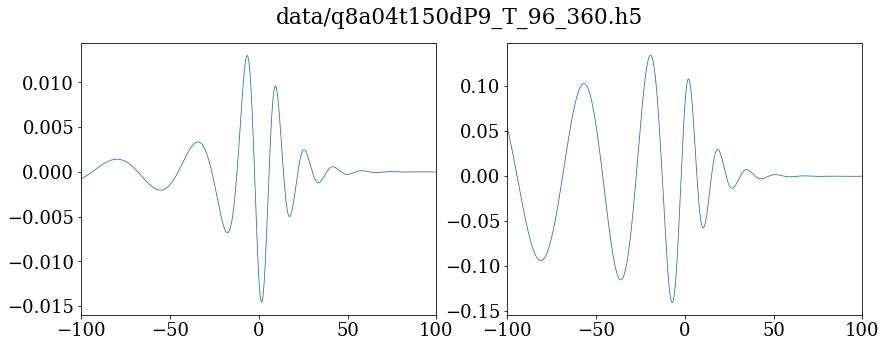

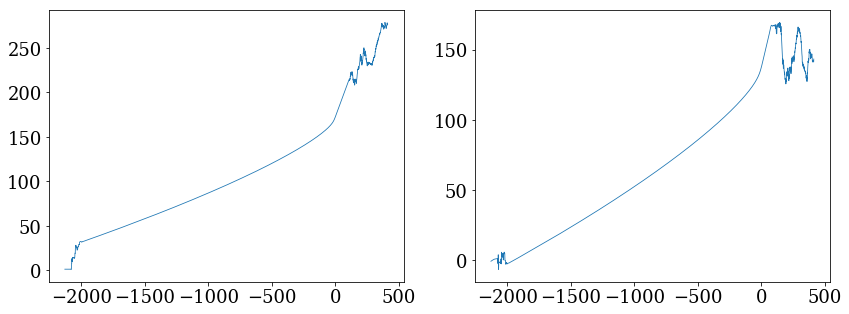

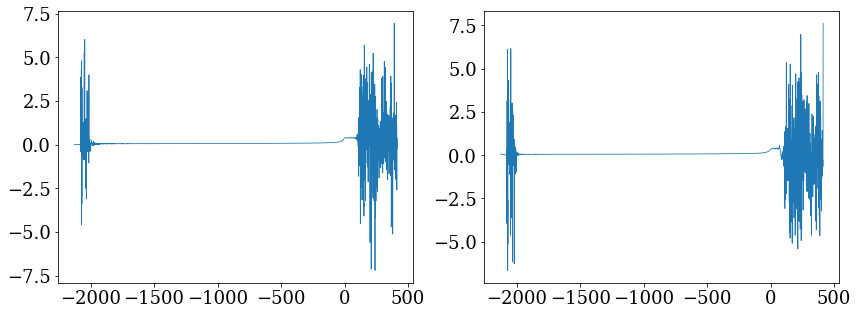

[u'psi4', u'strain', u'times']
[u'X1', u'X2', u'eta', u'simname']
<HDF5 dataset "times": shape (5000,), type "<f8">


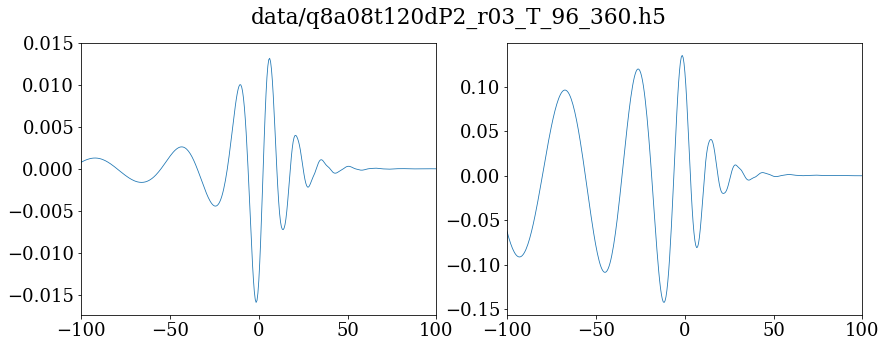

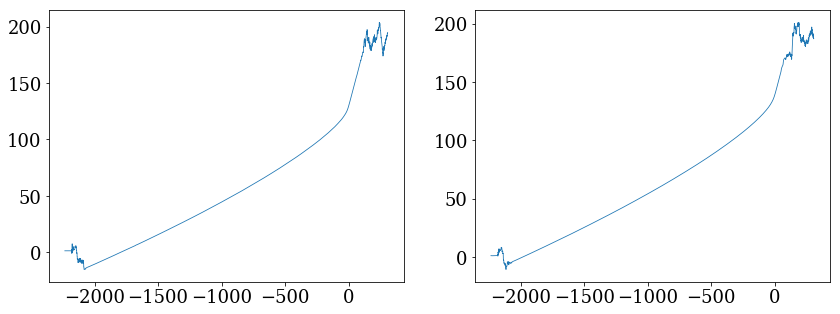

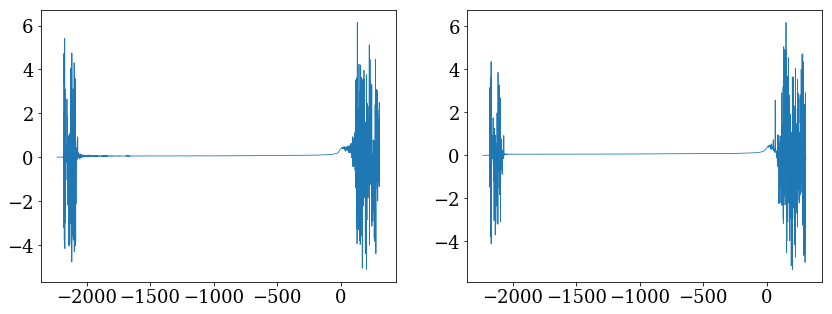

[u'psi4', u'strain', u'times']
[u'X1', u'X2', u'eta', u'simname']
<HDF5 dataset "times": shape (5000,), type "<f8">


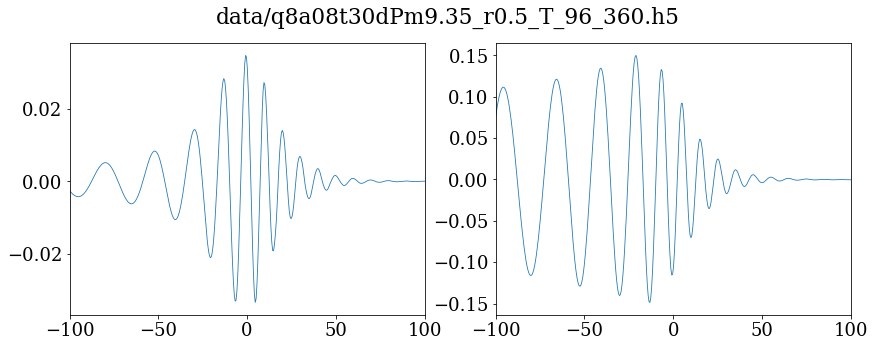

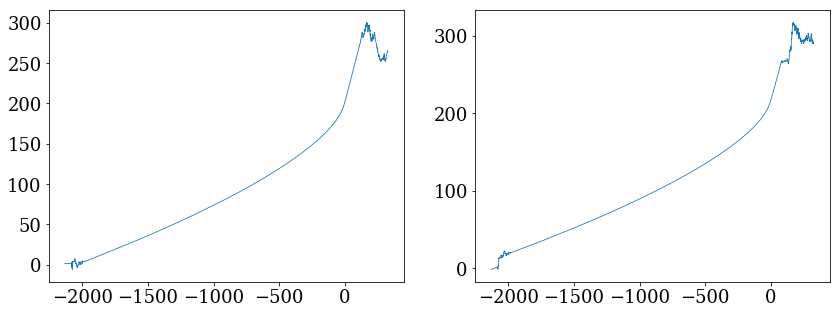

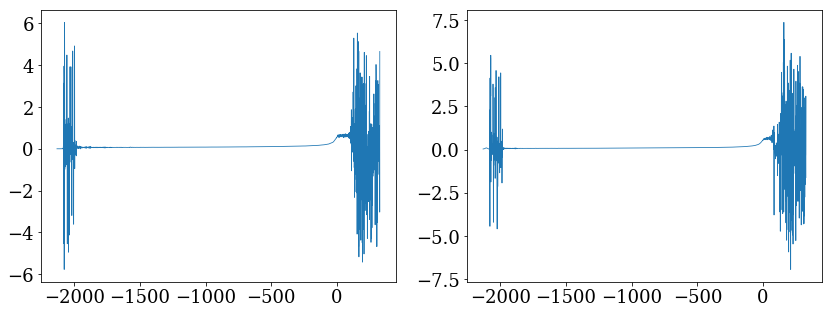

[u'psi4', u'strain', u'times']
[u'X1', u'X2', u'eta', u'simname']
<HDF5 dataset "times": shape (5000,), type "<f8">


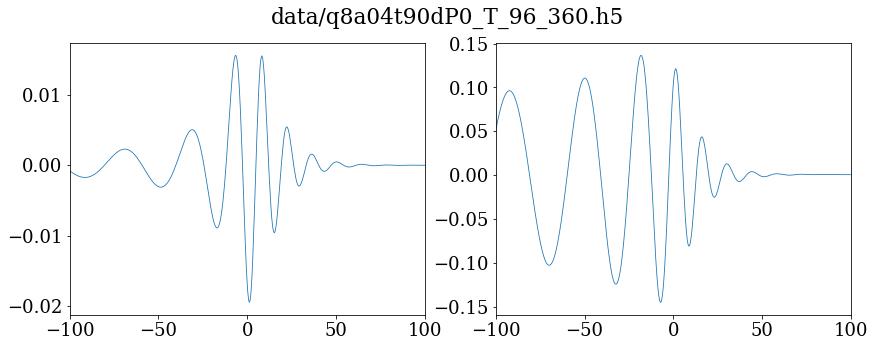

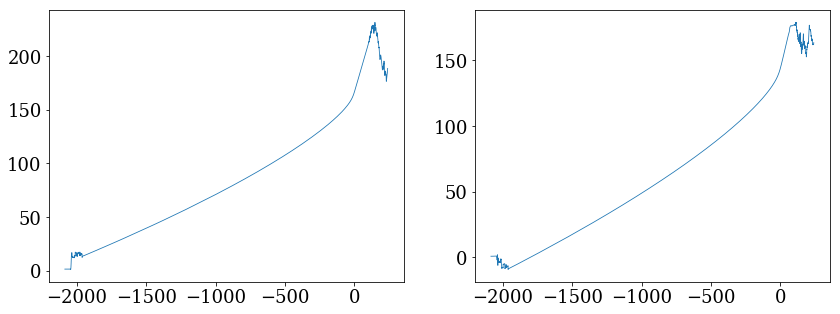

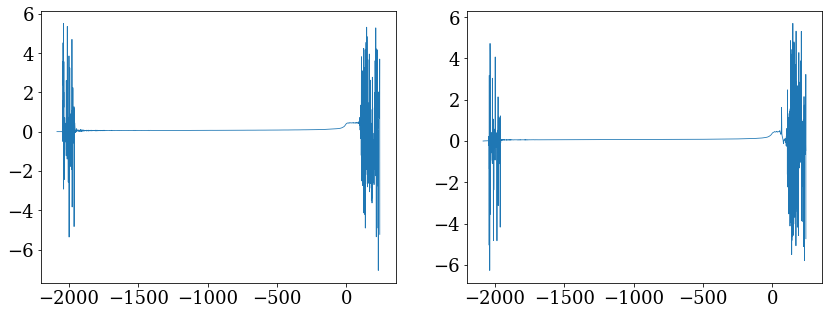

[u'psi4', u'strain', u'times']
[u'X1', u'X2', u'eta', u'simname']
<HDF5 dataset "times": shape (5000,), type "<f8">


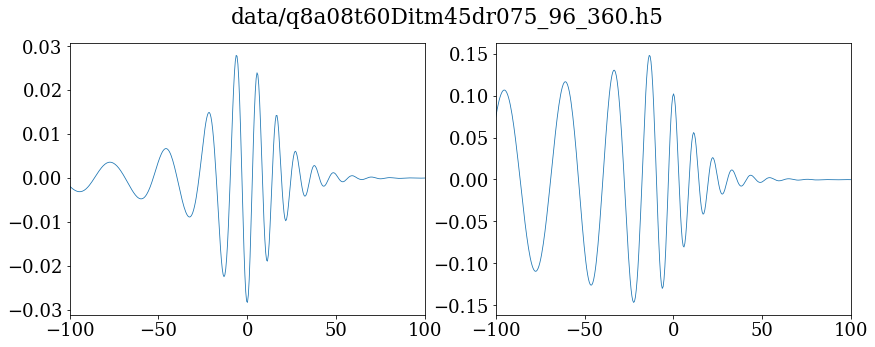

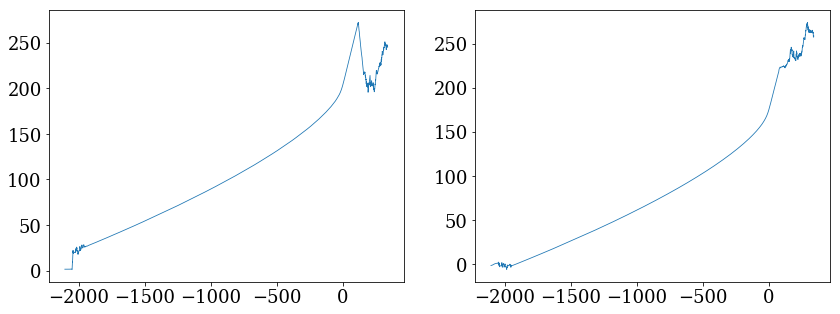

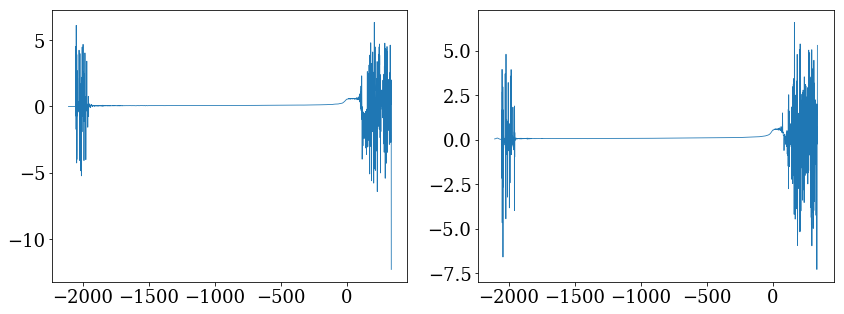

[u'psi4', u'strain', u'times']
[u'X1', u'X2', u'eta', u'simname']
<HDF5 dataset "times": shape (5000,), type "<f8">


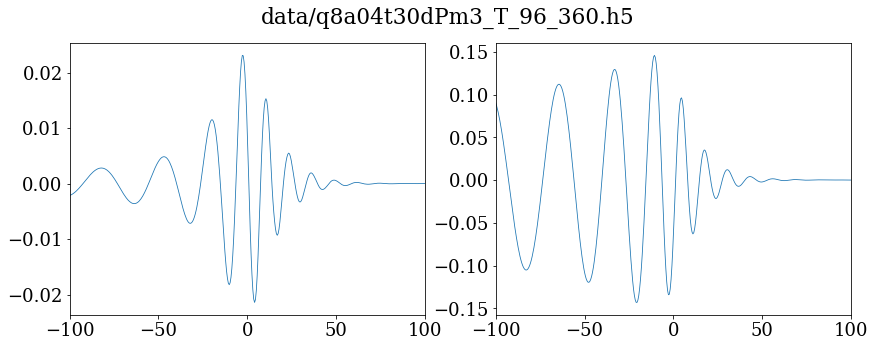

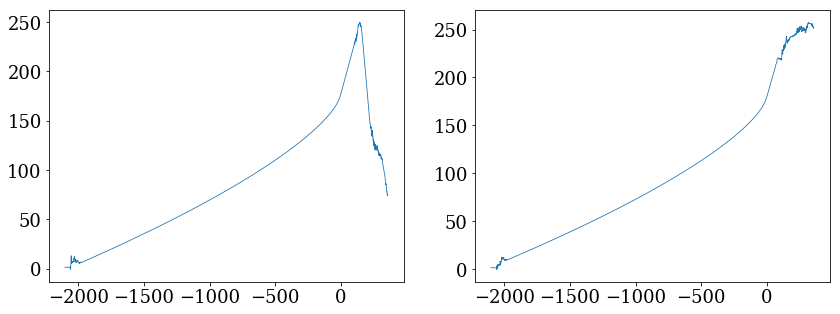

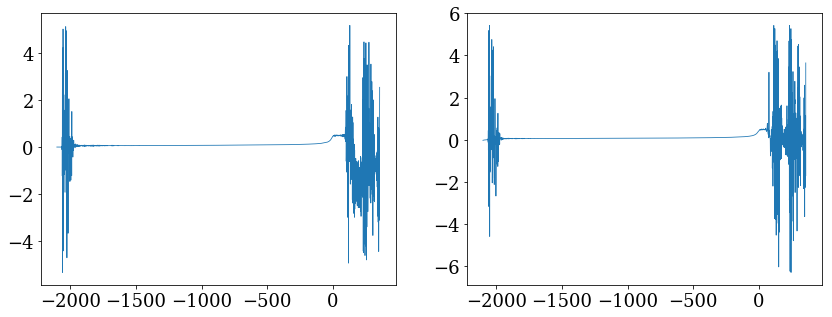

[u'psi4', u'strain', u'times']
[u'X1', u'X2', u'eta', u'simname']
<HDF5 dataset "times": shape (5000,), type "<f8">


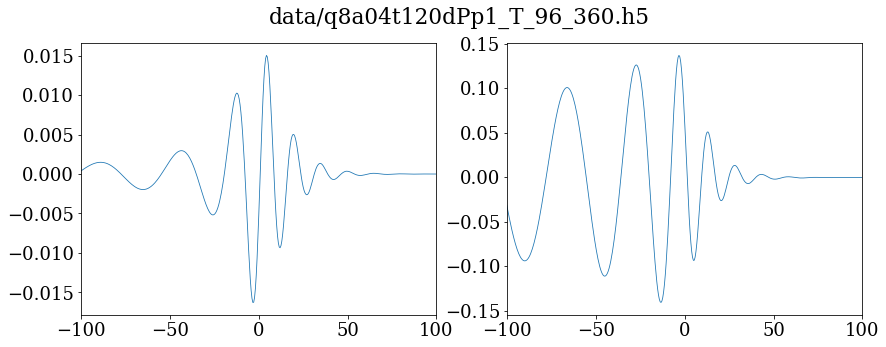

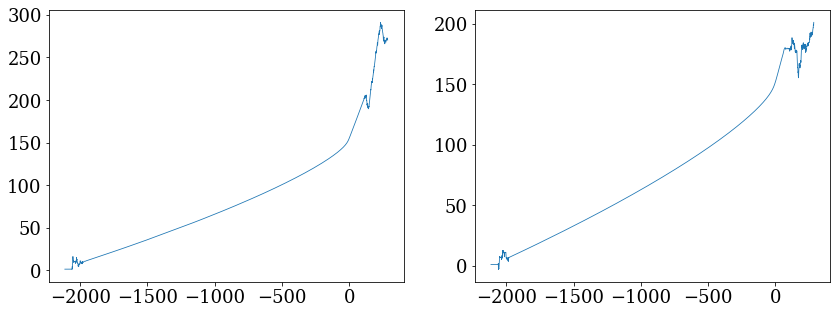

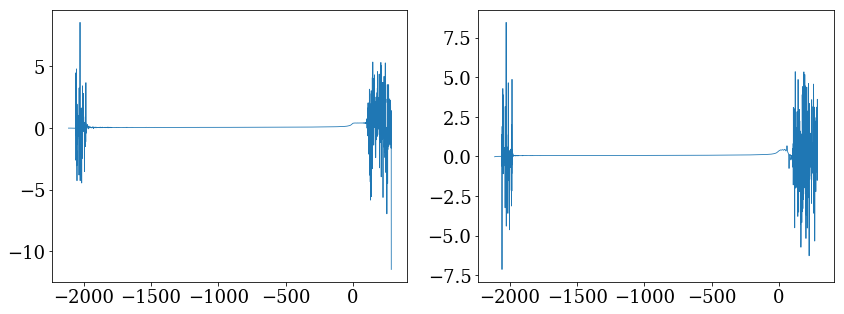

[u'psi4', u'strain', u'times']
[u'X1', u'X2', u'eta', u'simname']
<HDF5 dataset "times": shape (5000,), type "<f8">


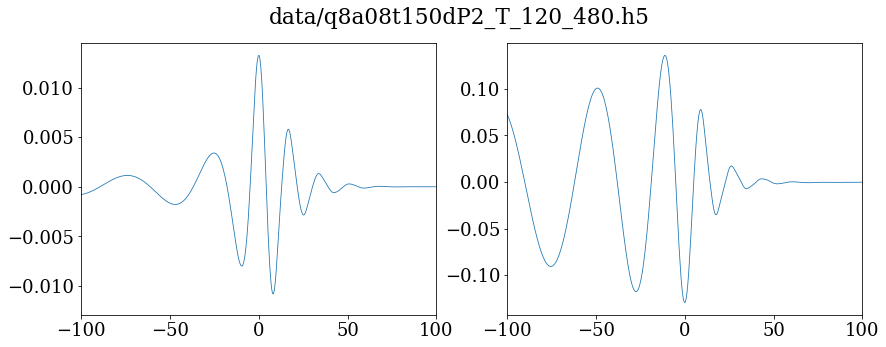

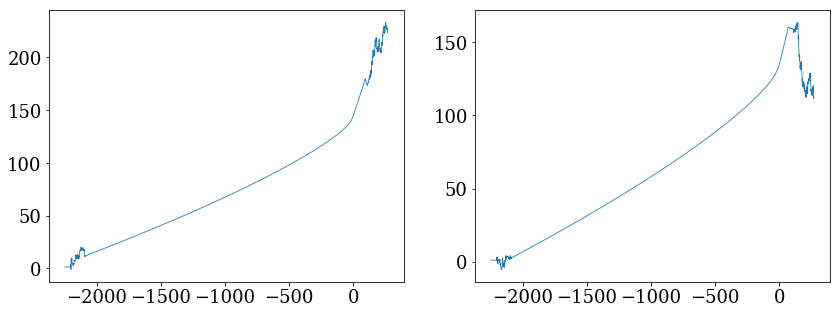

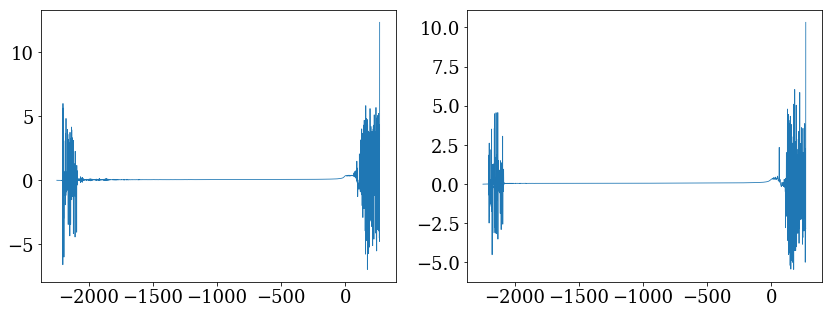

[u'psi4', u'strain', u'times']
[u'X1', u'X2', u'eta', u'simname']
<HDF5 dataset "times": shape (5000,), type "<f8">


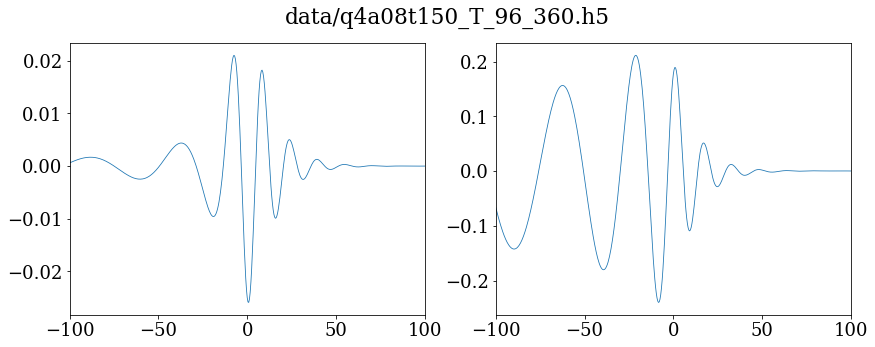

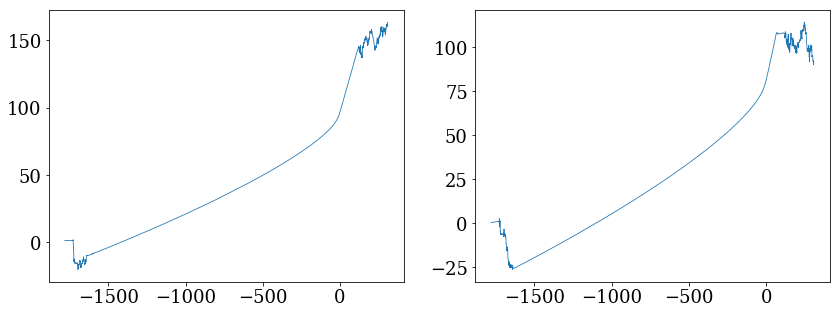

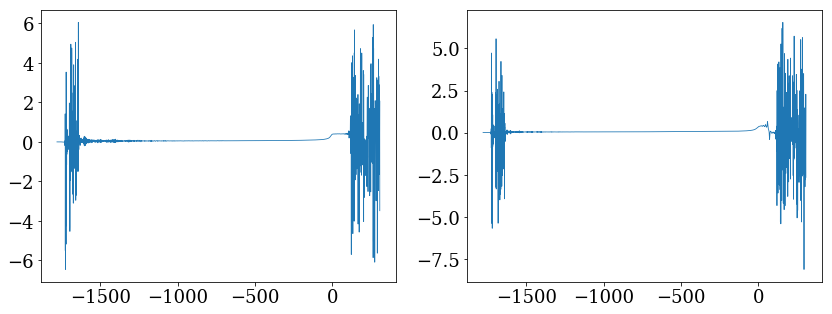

[u'psi4', u'strain', u'times']
[u'X1', u'X2', u'eta', u'simname']
<HDF5 dataset "times": shape (5000,), type "<f8">


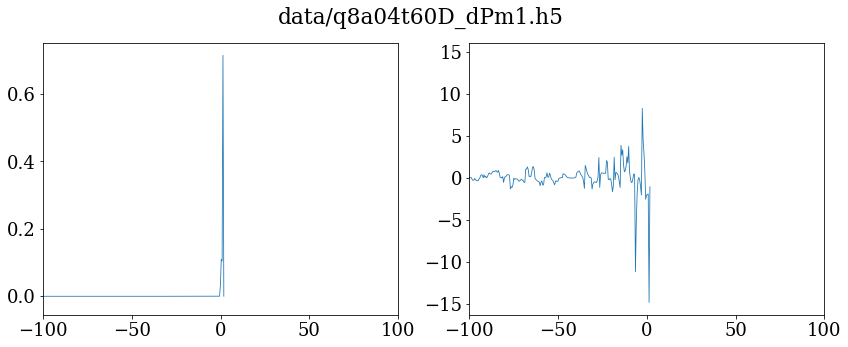

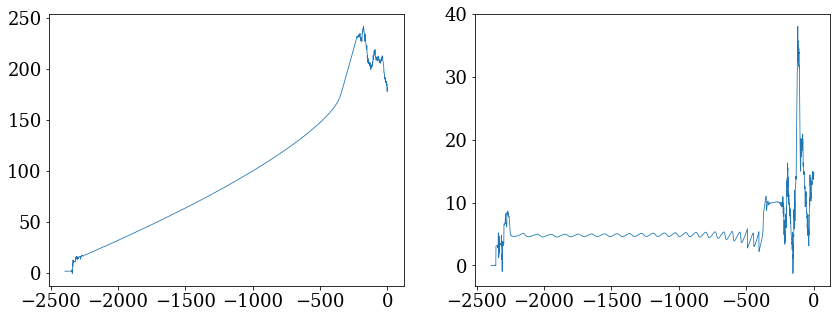

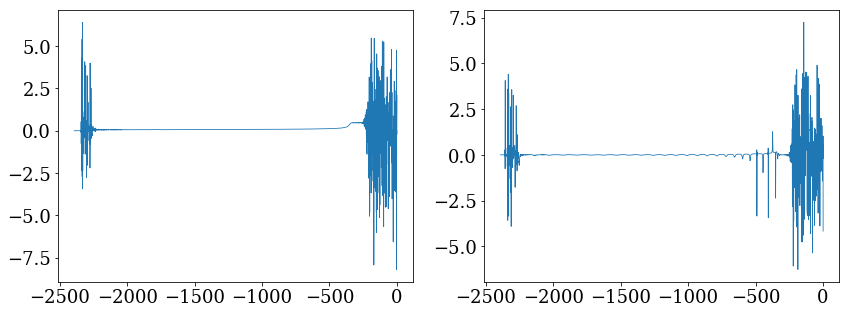

In [80]:
for data in all_data:
    t, psi4 = read_data(data)